In [106]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os

In [107]:
confidence_threshold = 0.3

nms_threshold = 0.2 

labels = open('../models/darknet/coco.names').read().strip().split("\n")
labels

['person',
 'bicycle',
 'car',
 'motorbike',
 'aeroplane',
 'bus',
 'train',
 'truck',
 'boat',
 'traffic light',
 'fire hydrant',
 'stop sign',
 'parking meter',
 'bench',
 'bird',
 'cat',
 'dog',
 'horse',
 'sheep',
 'cow',
 'elephant',
 'bear',
 'zebra',
 'giraffe',
 'backpack',
 'umbrella',
 'handbag',
 'tie',
 'suitcase',
 'frisbee',
 'skis',
 'snowboard',
 'sports ball',
 'kite',
 'baseball bat',
 'baseball glove',
 'skateboard',
 'surfboard',
 'tennis racket',
 'bottle',
 'wine glass',
 'cup',
 'fork',
 'knife',
 'spoon',
 'bowl',
 'banana',
 'apple',
 'sandwich',
 'orange',
 'broccoli',
 'carrot',
 'hot dog',
 'pizza',
 'donut',
 'cake',
 'chair',
 'sofa',
 'pottedplant',
 'bed',
 'diningtable',
 'toilet',
 'tvmonitor',
 'laptop',
 'mouse',
 'remote',
 'keyboard',
 'cell phone',
 'microwave',
 'oven',
 'toaster',
 'sink',
 'refrigerator',
 'book',
 'clock',
 'vase',
 'scissors',
 'teddy bear',
 'hair drier',
 'toothbrush']

([], [])

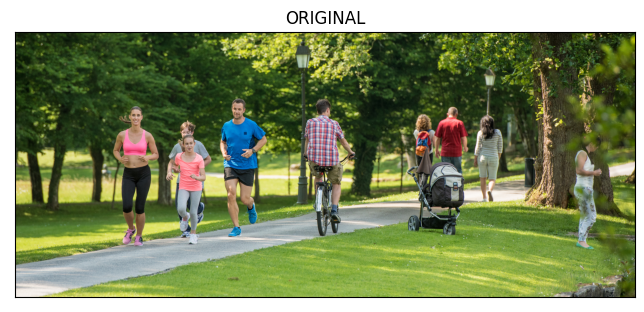

In [108]:
image = cv.imread('./people.jpg')
plt.figure(figsize=(8,8))
plt.imshow(image[:,:,::-1])
plt.title('ORIGINAL'); plt.xticks([]); plt.yticks([])

In [109]:
np.random.seed(42)
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype="uint8")

In [110]:
net = cv.dnn.readNetFromDarknet('../models/darknet/yolov3.cfg', '../models/darknet/yolov3.weights')
ln = net.getLayerNames()
ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

In [111]:
blob = cv.dnn.blobFromImage(image, 1 / 255.0, (608, 608), swapRB=True, crop=False)
net.setInput(blob)
layerOutputs = net.forward(ln)
H, W = image.shape[:2]

In [112]:
boxes = []
confidences = []
classIDs = []

# Loop over each of the layer outputs
for output in layerOutputs:
  # Loop over each of the detections
  for detection in output:
    # Extract the class ID and confidence (i.e., probability)
    # of the current object detection
    scores = detection[5:]
    classID = np.argmax(scores)
    confidence = scores[classID]
    
    if confidence > confidence_threshold:
      # Scale the bounding box coordinates back relative to
      # the size of the image, keeping in mind that YOLO
      # actually returns the center (x, y)-coordinates of
      # the bounding box followed by the boxes' width and
      # height
      box = detection[0:4] * np.array([W, H, W, H])
      (centerX, centerY, width, height) = box.astype("int")

      # Use the center (x, y)-coordinates to derive the top
      # and and left corner of the bounding box
      x = int(centerX - (width / 2))
      y = int(centerY - (height / 2))

      if labels[classID] == 'person':
        classIDs.append(classID)
        boxes.append([x, y, int(width), int(height)])
        confidences.append(float(confidence))
    


([], [])

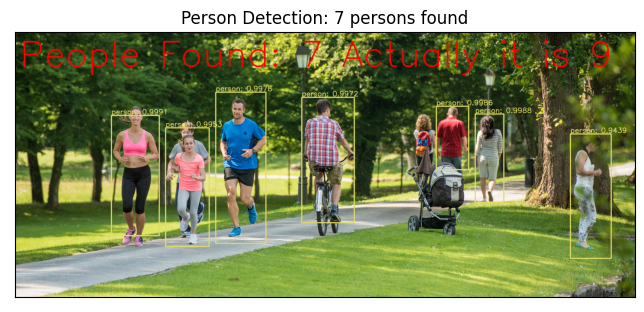

In [113]:
# Apply non-maximum suppression to suppress weak, overlapping bounding boxes
idxs = cv.dnn.NMSBoxes(boxes, confidences, confidence_threshold, nms_threshold)

# Ensure that at least one detection exists
if len(idxs) > 0:
  # Loop over the indexes we are keeping
  for i in idxs.flatten():
    # Extract the bounding box coordinates
    (x, y) = (boxes[i][0], boxes[i][1])
    (w, h) = (boxes[i][2], boxes[i][3])

    #  draw bounding box and class label on image
    color = [int(c) for c in colors[classIDs[i]]]
    cv.rectangle(image, (x, y), (x + w, y + h), color, 3)
    text = "{}: {:.4f}".format(labels[classIDs[i]], confidences[i])
    cv.putText(image, text, (x, y - 5), cv.FONT_HERSHEY_SIMPLEX, 1, color, 2)

  cv.putText(image, f"People Found: {len(idxs)} Actually it is 9 ", (20, 150),  cv.FONT_HERSHEY_SIMPLEX, 5, (0, 0, 255), 5)

# Display the output image
plt.figure(figsize=(8,8))
plt.imshow(image[:,:,::-1])
plt.title(f'Person Detection: {len(idxs)} persons found'); plt.xticks([]); plt.yticks([])
